<a href="https://colab.research.google.com/github/subhadhana99/Item-demand-forecasting/blob/main/project(item_demand_prediction).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [199]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
from matplotlib.pyplot import figure
from datetime import timedelta
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from xgboost.sklearn import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn import metrics as metrics
from sklearn.metrics import mean_absolute_error,mean_squared_error


# **Problem** **Statement**#
Demand forecasts are fundamental to plan and deliver products and services. Accurate forecasting of demand can help the manufacturers to maintain appropriate stock which results in reduction in loss due to product not being sold and also reduces the opportunity cost (i.e. higher demand but less availability => opportunity lost). Despite such relevance, manufacturers have difficulty choosing which forecast model is the best for their use case. In this project, historical sales data corresponding to multiple(50) items sold in 10 stores are provided and participants are expected to come up with a best model to predict the future demand for products which results in maximum profit for the manufacturer. Predict the demand for the next 3 months at the item level (i.e. all the stores combined).

#**Data**#
From the historical sales data item, store and sales details are provided at the daily level for a period spanning 4 years. 

#**Objective**#
The end objective is to produce a model that gives the best prediction to the manufacturer. Such a model must include the seasonality of the items sold. 



In [200]:
# Importing the sales data from google drive
df = pd.read_csv('/content/drive/MyDrive/train 2.csv')
df

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10
...,...,...,...,...
912995,2017-12-27,10,50,63
912996,2017-12-28,10,50,59
912997,2017-12-29,10,50,74
912998,2017-12-30,10,50,62


In [201]:
#!pip install autoviz

In [202]:
#from autoviz.AutoViz_Class import AutoViz_Class
#AV = AutoViz_Class()

#%matplotlib inline 
#AV.AutoViz('/content/drive/MyDrive/train 2.csv')

In [203]:
df.shape


(913000, 4)

In [204]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB


from the info we found that date is object type we need to convert that into date time format

In [205]:
#converting Date into datetime format
df['date'] = pd.to_datetime(df['date'],format='%Y/%m/%d')


In [206]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    913000 non-null  datetime64[ns]
 1   store   913000 non-null  int64         
 2   item    913000 non-null  int64         
 3   sales   913000 non-null  int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 27.9 MB


Our data are in right type now. We proceed further

In [207]:
#checking for missing values
df.isnull().sum()

date     0
store    0
item     0
sales    0
dtype: int64

In [208]:
df.isna().mean()

date     0.0
store    0.0
item     0.0
sales    0.0
dtype: float64

No missing values present in the data

In [209]:
#checking for duplicates
df[df.duplicated()]

,date,store,item,sales


In [210]:
df.describe()

,store,item,sales
count,913000.000000,913000.000000,913000.000000
mean,5.500000,25.500000,52.250287
std,2.872283,14.430878,28.801144
min,1.000000,1.000000,0.000000
25%,3.000000,13.000000,30.000000
50%,5.500000,25.500000,47.000000
75%,8.000000,38.000000,70.000000
max,10.000000,50.000000,231.000000


In [211]:
df["date"].min(), df["date"].max() 

(Timestamp('2013-01-01 00:00:00'), Timestamp('2017-12-31 00:00:00'))

In [212]:
# to find number of stores in the data
df[["store"]].nunique()

store    10
dtype: int64

 In the give data sales has been done in 10 stores 

In [213]:
# to find number of items sold 
df[["item"]].nunique()

item    50
dtype: int64

There are 50 items Present in the data

In [214]:
df.groupby(["item"]).agg({"sales": ["count","sum", "mean", "median", "std", "min", "max"]})

sales                                               
      count      sum       mean median        std min  max
item                                                      
1     18260   401384  21.981599   21.0   8.468922   1   59
2     18260  1069564  58.574151   56.0  20.093015   9  150
3     18260   669087  36.642223   35.0  13.179441   7  104
4     18260   401907  22.010241   21.0   8.403898   0   66
5     18260   335230  18.358708   18.0   7.265167   1   50
6     18260  1068281  58.503888   56.0  20.174898  11  148
7     18260  1068777  58.531051   56.0  20.146002  11  141
8     18260  1405108  76.950055   74.0  26.130697  15  181
9     18260   938379  51.389869   49.5  17.790158   6  134
10    18260  1337133  73.227437   70.0  24.823725  14  175
11    18260  1271925  69.656353   67.0  23.744732  11  170
12    18260  1271534  69.634940   67.0  23.738663  12  170
13    18260  1539621  84.316594   81.0  28.311031  20  210
14    18260  1071531  58.681873   56.0  20.079860  12  152
15    18260  1607442  88.030778   85.0  29.522852  17  231
16    18260   468480  25.656079   25.0   9.603270   2   70
17    18260   602486  32.994852   32.0  11.967610   4   83
18    18260  1538876  84.275794   81.0  28.430621  18  208
19    18260   736892  40.355531   39.0  14.332645   5   99
20    18260   867641  47.515936   46.0  16.490487   9  127
21    18260   736190  40.317087   39.0  14.338006   7  109
22    18260  1469971  80.502245   78.0  27.118163  14  214
23    18260   534979  29.297864   28.0  10.819549   3   81
24    18260  1205975  66.044633   64.0  22.531555  14  156
25    18260  1473334  80.686418   78.0  27.238817  18  193
26    18260   869981  47.644085   46.0  16.723912   8  119
27    18260   402628  22.049726   21.0   8.461641   1   59
28    18260  1604713  87.881325   85.0  29.501781  16  206
29    18260  1271240  69.618839   67.0  23.635631  15  173
30    18260   736554  40.337021   39.0  14.363331   5  115
31    18260  1070845  58.644304   57.0  20.104705  10  159
32    18260   803107  43.981763   42.0  15.574556   5  119
33    18260  1270183  69.560953   67.0  23.718343  15  169
34    18260   469935  25.735761   25.0   9.617910   2   79
35    18260  1201541  65.801807   63.0  22.461990  12  168
36    18260  1406548  77.028916   74.0  26.067440  16  188
37    18260   534258  29.258379   28.0  10.771547   3   74
38    18260  1470330  80.521906   77.0  27.141799  15  188
39    18260   801311  43.883406   42.0  15.511550   7  112
40    18260   534094  29.249398   28.0  10.822959   3   74
41    18260   401759  22.002136   21.0   8.402470   2   60
42    18260   669925  36.688116   35.0  13.215112   5   96
43    18260   936635  51.294359   49.0  17.801008   9  126
44    18260   536811  29.398193   28.0  10.797738   3   78
45    18260  1471467  80.584173   78.0  27.318402  18  205
46    18260  1070764  58.639869   56.0  20.220879  11  150
47    18260   401781  22.003341   21.0   8.420102   2   61
48    18260   937703  51.352848   49.0  17.881917   8  130
49    18260   535663  29.335323   28.0  10.874788   3   77
50    18260  1203009  65.882202   63.0  22.416031  12  164

# Aggregating the  data Item wise  
 
 Finding daily sales of Item irrespective of store 


In [215]:
df1=df.groupby(["item","date"],as_index=False)["sales"].agg({"sales":"sum"})
df1


,item,date,sales
0,1,2013-01-01,133
1,1,2013-01-02,99
2,1,2013-01-03,127
3,1,2013-01-04,145
4,1,2013-01-05,149
...,...,...,...
91295,50,2017-12-27,511
91296,50,2017-12-28,587
91297,50,2017-12-29,596
91298,50,2017-12-30,612


# Aggregated the Item sales on 3 month Basis 
 rolling sum of 90 days is calculated for each item on the corresponding dates 

In [216]:
df1=pd.DataFrame(df1.set_index("date").sort_index(ascending=False).groupby(['item'],as_index=False).rolling('90d',min_periods=0).sales.sum().sort_index().to_frame()).reset_index()
df1

,item,date,sales
0,1,2013-01-01,12847.0
1,1,2013-01-02,12848.0
2,1,2013-01-03,12936.0
3,1,2013-01-04,13019.0
4,1,2013-01-05,13103.0
...,...,...,...
91295,50,2017-12-27,2932.0
91296,50,2017-12-28,2421.0
91297,50,2017-12-29,1834.0
91298,50,2017-12-30,1238.0


In [217]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91300 entries, 0 to 91299
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   item    91300 non-null  int64         
 1   date    91300 non-null  datetime64[ns]
 2   sales   91300 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 2.1 MB


In [218]:
df1[df1.duplicated()]

,item,date,sales


In [219]:
df1

,item,date,sales
0,1,2013-01-01,12847.0
1,1,2013-01-02,12848.0
2,1,2013-01-03,12936.0
3,1,2013-01-04,13019.0
4,1,2013-01-05,13103.0
...,...,...,...
91295,50,2017-12-27,2932.0
91296,50,2017-12-28,2421.0
91297,50,2017-12-29,1834.0
91298,50,2017-12-30,1238.0


In [220]:
df1.isnull().sum()

item     0
date     0
sales    0
dtype: int64

In [221]:
df.isnull().mean()

date     0.0
store    0.0
item     0.0
sales    0.0
dtype: float64

In [222]:
#df1.drop(df1.tail(90).index,inplace=True)

In [223]:
df1

,item,date,sales
0,1,2013-01-01,12847.0
1,1,2013-01-02,12848.0
2,1,2013-01-03,12936.0
3,1,2013-01-04,13019.0
4,1,2013-01-05,13103.0
...,...,...,...
91295,50,2017-12-27,2932.0
91296,50,2017-12-28,2421.0
91297,50,2017-12-29,1834.0
91298,50,2017-12-30,1238.0


# Feature Engineering
 Since this dataset has very less features ,new features are introduced in order to enhance the models

In [224]:
def create_date_features(df):
    df["end_date"]=df["date"] + timedelta(90)
    df['year'] = df.date.dt.year
    df['month'] = df.date.dt.month
    df['day'] = df.date.dt.day
    df['days_month']=df.date.dt.days_in_month
    df['is_month_start'] = df.date.dt.is_month_start.astype(int)
    df['is_month_end'] = df.date.dt.is_month_end.astype(int)
    df['year_start']=df.date.dt.is_year_start.astype(int)
    df['year_end']=df.date.dt.is_year_end.astype(int)
    df['is_leap_year']=df.date.dt.is_leap_year.astype(int)
    df['day_of_year'] = df.date.dt.dayofyear
    df['week_of_year'] = df.date.dt.weekofyear
    df['day_of_week'] = df.date.dt.dayofweek
    df["is_wknd"] = df.date.dt.weekday // 4
    df["quater"]=df.date.dt.quarter
    df['is_quater_start']=df.date.dt.is_quarter_start.astype(int)
    df['is_quater_end']=df.date.dt.is_quarter_end.astype(int)
    

    return df
create_date_features(df1)

<ipython-input-224-670648d6fd5f>:13: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['week_of_year'] = df.date.dt.weekofyear


,item,date,sales,end_date,year,month,day,days_month,is_month_start,is_month_end,year_start,year_end,is_leap_year,day_of_year,week_of_year,day_of_week,is_wknd,quater,is_quater_start,is_quater_end
0,1,2013-01-01,12847.0,2013-04-01,2013,1,1,31,1,0,1,0,0,1,1,1,0,1,1,0
1,1,2013-01-02,12848.0,2013-04-02,2013,1,2,31,0,0,0,0,0,2,1,2,0,1,0,0
2,1,2013-01-03,12936.0,2013-04-03,2013,1,3,31,0,0,0,0,0,3,1,3,0,1,0,0
3,1,2013-01-04,13019.0,2013-04-04,2013,1,4,31,0,0,0,0,0,4,1,4,1,1,0,0
4,1,2013-01-05,13103.0,2013-04-05,2013,1,5,31,0,0,0,0,0,5,1,5,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91295,50,2017-12-27,2932.0,2018-03-27,2017,12,27,31,0,0,0,0,0,361,52,2,0,4,0,0
91296,50,2017-12-28,2421.0,2018-03-28,2017,12,28,31,0,0,0,0,0,362,52,3,0,4,0,0
91297,50,2017-12-29,1834.0,2018-03-29,2017,12,29,31,0,0,0,0,0,363,52,4,1,4,0,0
91298,50,2017-12-30,1238.0,2018-03-30,2017,12,30,31,0,0,0,0,0,364,52,5,1,4,0,0


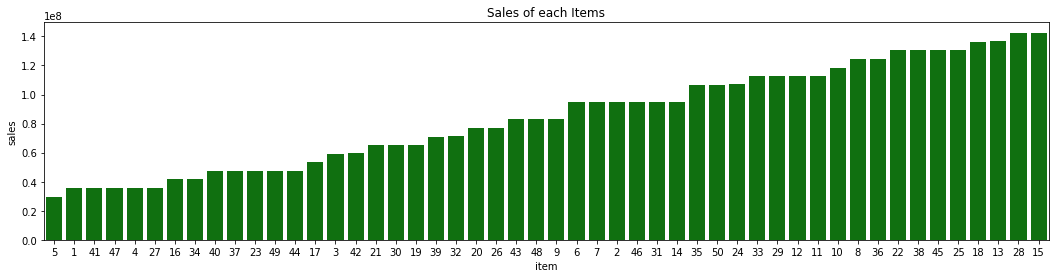

In [225]:
plt.figure(figsize=(18, 4))
item_sum = df1.groupby(["item"],as_index=False).agg({"sales": "sum"}).sort_values(by="sales",ascending=True)
sns.barplot(data=item_sum,x='item',y='sales',color="green",order=item_sum.sort_values('sales').item).set(title='Sales of each Items')
plt.show()

*From the above plot we observe that 15th item has been sold maximum and 5th item is sold minimum in the given Duration*


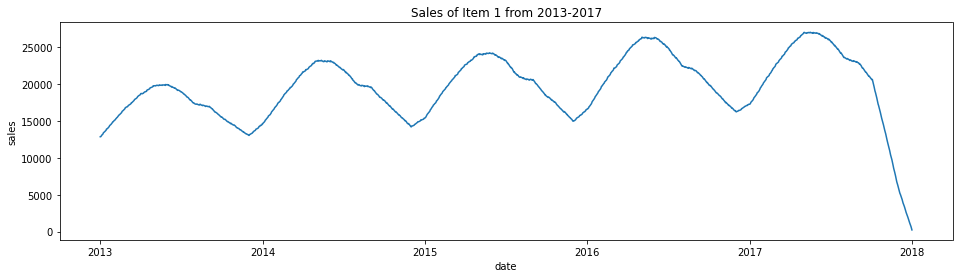

In [226]:
plt.figure(figsize=(16, 4))
df1['date'] = pd.to_datetime(df1.date, format='%Y/%m/%d')
item_1 = df1[df1['item']==1]
sns.lineplot(data=item_1,x='date',y='sales').set(title='Sales of Item 1 from 2013-2017')
plt.show()

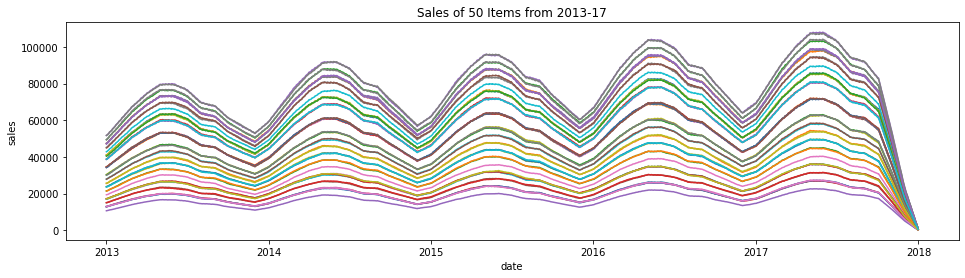

In [227]:
plt.figure(figsize=(16, 4))
for i in range(1,51):
  item = df1[df1['item']==i]
  sns.lineplot(data=item,x='date',y='sales').set(title='Sales of 50 Items from 2013-17')
plt.show()

*From the Above Plot it is evident that all 50 items follow a cyclic Trend.*

In [228]:
#correlation between the features 
cor=df1.corr()

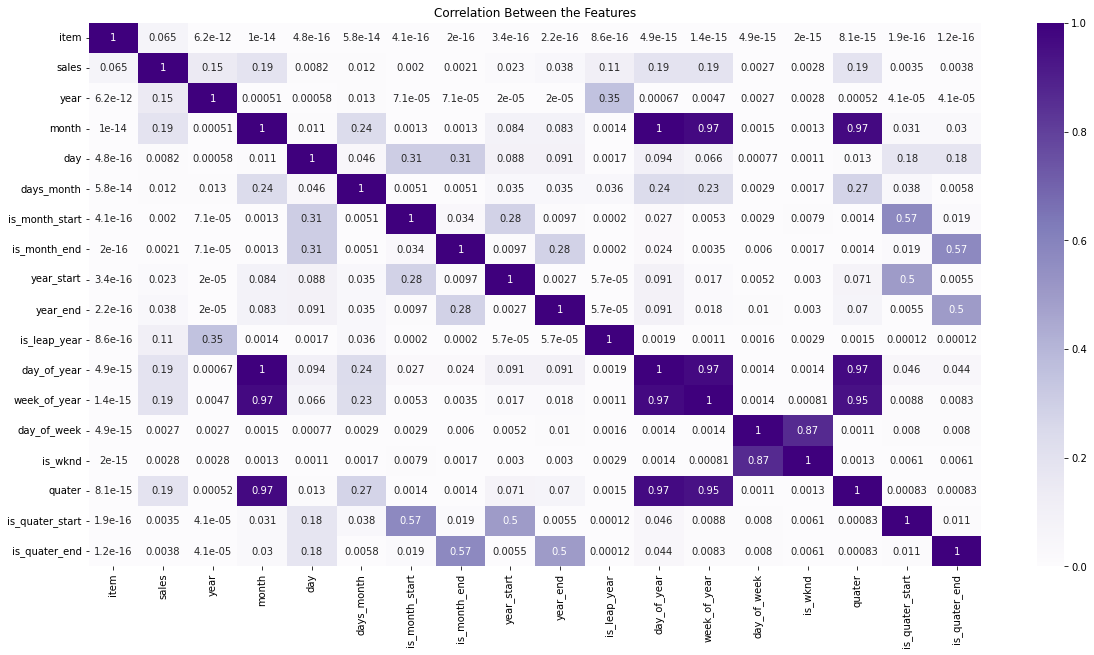

In [229]:
plt.figure(figsize=(20,10))
sns.heatmap(cor.abs(),annot=True,cmap='Purples').set(title='Correlation Between the Features')
plt.show()

In [230]:
#item=2
#df_item=df1[df1['item']==item]
#df_item
#'week_of_year','day_of_year',

In [231]:
#Splitting the data into train and test
def train_test_split(item):
  df_item=df1[df1['item']==item]
  #df_item=df_item.sample(frac=1)
#splitting of data into train and split:
  df_train=df_item[(df_item['year']<2017)]
  df_test=df_item[(df_item['year']==2017)]
  y_train=df_train['sales']
  Features=['item', 'year', 'month', 'day', 'days_month', 'is_month_start', 'is_month_end', 'day_of_year', 'week_of_year', 'day_of_week', 'is_wknd', 'quater', 'is_quater_start', 'is_quater_end','year_start','year_end','is_leap_year']
  x_train=df_train[Features]
  y_test=df_test["sales"]
  x_test=df_test[Features]

#scaling the data
  scaler = StandardScaler() 
  scaler.fit(x_train) 
  X_train_scaled = scaler.transform(x_train) 
  X_test_scaled = scaler.transform(x_test)
  return(X_train_scaled,y_train,X_test_scaled,y_test)


In [232]:
def linear_reg(item):
   x_train,y_train,x_test,y_test= train_test_split(item)
   mod= LinearRegression()
   mod.fit(x_train, y_train)
   predictions = mod.predict(x_test)
   result=pd.DataFrame({'Actual': y_test, 'Predicted': predictions})
   rsquare= metrics.r2_score(y_test,predictions)
   MAE=metrics.mean_absolute_error(y_test,predictions)
   return rsquare

In [233]:
#temp,lintemp=[],[]
#for i in range(1,51):
  #lintemp.append(linear_reg(i))
  #temp.append(i)
#df_score=pd.DataFrame({'Item':temp ,'r_square':lintemp})
#df_score

In [234]:
def regressive_model(model,x_train,y_train,x_test,y_test ):
   mod = model
   mod.fit(x_train, y_train)
   predictions = mod.predict(x_test)
   result=pd.DataFrame({'Actual': y_test, 'Predicted': predictions})
   rsquare=mod.scores(y_test,predictions)
   MAE=metrics.mean_absolute_error(y_test,predictions)
   return rsquare
   
 

In [235]:
itm,mdl,mdl2,mdl3,mdl4=[],[],[],[],[]
for i in range(1,51):
   x_train,y_train,x_test,y_test= train_test_split(i)
   mdl.append(regressive_model(LinearRegression(),x_train,y_train,x_test,y_test))
   mdl2.append(regressive_model( DecisionTreeRegressor(),x_train,y_train,x_test,y_test))
   mdl3.append(regressive_model(KNeighborsRegressor(),x_train,y_train,x_test,y_test ))
   mdl4.append(regressive_model(XGBRegressor(),x_train,y_train,x_test,y_test))
   #mdl.append(regressive_model())
   itm.append(i)
dfl_score=pd.DataFrame({'Item':itm ,'regression':mdl,'decisiontree':mdl2,'KNN':mdl3,'XGbreg':mdl4})
dfl_score


,Item,regression,decisiontree,KNN,XGbreg
0,1,0.156308,0.497193,0.524615,0.562430
1,2,0.178572,0.573016,0.498065,0.572852
2,3,0.167393,0.540991,0.506504,0.566851
3,4,0.169196,0.531042,0.517435,0.581065
4,5,0.205201,0.461849,0.504207,0.560876
5,6,0.189496,0.470304,0.508272,0.566695
6,7,0.189014,0.549042,0.517962,0.572563
7,8,0.187002,0.506782,0.503138,0.573350
8,9,0.148341,0.603507,0.520050,0.552704
9,10,0.183116,0.551432,0.500305,0.560779


In [237]:
#@title
df_train=df1[(df1['year']<2017)]
df_test=df1[(df1['year']==2017)]
y_train=df_train['sales']
Features=['item', 'year', 'month', 'day', 'days_month', 'is_month_start', 'is_month_end', 'day_of_year', 'week_of_year', 'day_of_week', 'is_wknd', 'quater', 'is_quater_start', 'is_quater_end','year_start','year_end','is_leap_year']
x_train=df_train[Features]
y_test=df_test["sales"]
x_test=df_test[Features]

#scaling the data
scaler = StandardScaler() 
scaler.fit(x_train) 
X_train_scaled = scaler.transform(x_train) 
X_test_scaled = scaler.transform(x_test)



In [250]:
reg_dt=DecisionTreeRegressor(random_state=0)
reg_dt.fit(X_train_scaled,y_train)
y_preddt=reg_dt.predict(X_test_scaled)
metrics.r2_score(y_test,y_preddt)

0.7968746784413223

In [254]:
reg_xg=XGBRegressor()
reg_xg.fit(X_train_scaled,y_train)
y_preddt=reg_xg.predict(X_test_scaled)
metrics.r2_score(y_test,y_preddt)

0.8008383840077835

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

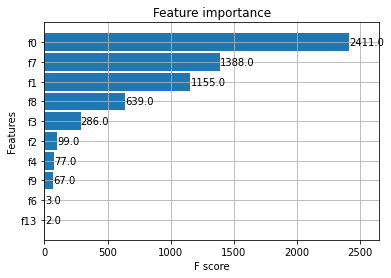

In [259]:
from xgboost import plot_importance
plot_importance(reg_xg, height=0.9)

Xg Boost regressor best predicts the sales data 